# Tutorial: Load data into an `KielMATRecording` object

**Author:** Julius Welzel
**Last update:** Fri 22 Mar 2024

## Learning objectives
By the end of this tutorial:
- you can load data and channel information into an `KielMATRecording` object
- you can add Recording specific information to the `KielMATRecording` object
- you are educated about the relationship between a `KielMATRecording` object and the [BIDS standard](https://bids-specification.readthedocs.io/en/stable/).

## Imports

We start by importing some Python libraries. You should be familiar with most of them, and we will not discuss them here.

In [12]:
import pandas as pd

from kielmat.utils.kielmat_dataclass import KielMATRecording # Import the KielMATRecording class
from kielmat.modules.gsd import ParaschivIonescuGaitSequenceDetection # Import the Gait Sequence Detection module

## Read the raw data and metadata into python

Let us consider a single recording, a accelerometer located at the lower back.
The sensor only provided the raw data in a csv file without any metadata. We only know the metadata from the sensor manual and from setting up the sensor.
Depending on the sensor, the metadata might be stored in a separate file or in the same file as the raw data as a header.

To import data from your own devices, check if KielMAT already has a reader for your device. If not, you can write your own reader and contribute it to the KielMAT project.

In [13]:
# Set the url for the raw data on GH
file_url = 'https://raw.githubusercontent.com/neurogeriatricskiel/KielMAT/main/examples/data/ExampleAccelDataRaw.csv'

# read the csv data from the url
acc_data = pd.read_csv(file_url)

# specifiy the sampling rate
fs = 100 # Hz

We have loaded the data for one tracking systems, `LB_ACCEL`. We know we have three channels: `x`, `y`, and `z`. We also know that the data is sampled at 100 Hz.

Let's check if the data is loaded correctly. We know we have a good 15 minutes of data with three channels representing acceleration.


In [14]:
n_channels = acc_data.shape[1]
n_samples = acc_data.shape[0]

# check how many minutes of data we have
n_minutes = n_samples/fs/60
print(f"Minutes of data: {n_minutes:.2f}")


Minutes of data: 18.33


Now we can load the data into an `KielMATRecording` object.
For this we have to construct the channel information oursleves. We know that the data is sampled at 100 Hz and we have three channels: `x`, `y`, and `z`.
For more information in the channel information, see the [BIDS standard](https://bids-specification.readthedocs.io/en/stable/modality-specific-files/motion.html#channels-description-_channelstsv).

**CAVE**:
If the naming of the channels df is not following the BIDS standard, you will receive an error.

In [15]:
# construct the channel information

tracked_point = "lowerBack"

n_channels = acc_data.shape[1] # second dimension of the data represents the number of channels

col_names = [
    f"{tracked_point}_{s}_{x}"
    for s in ["ACCEL"]
    for x in ["x", "y", "z"]
]

# Make the channel dictionary following the BIDS naming conventions
channels_dict = {
    "name": col_names,
    "component": ["x", "y", "z"] * (n_channels // 3),
    "type": ["ACCEL"] * (n_channels),
    "tracked_point": [tracked_point] * n_channels,
    "units": ["m/s^2"] * n_channels,
    "sampling_frequency": [fs] * n_channels,
}

recording =  KielMATRecording(
    data={"imu": acc_data}, channels={"lb_imu": pd.DataFrame(channels_dict)}
)

Ahh, perfect. Let's first inspect the channels in the dataclass.

In [16]:
recording.channels

{'lb_imu':                 name component   type tracked_point  units  sampling_frequency
 0  lowerBack_ACCEL_x         x  ACCEL     lowerBack  m/s^2                 100
 1  lowerBack_ACCEL_y         y  ACCEL     lowerBack  m/s^2                 100
 2  lowerBack_ACCEL_z         z  ACCEL     lowerBack  m/s^2                 100}

Now we can run some of our modules on this data. For example, we find gait sequences in our data.

20 gait sequence(s) detected.


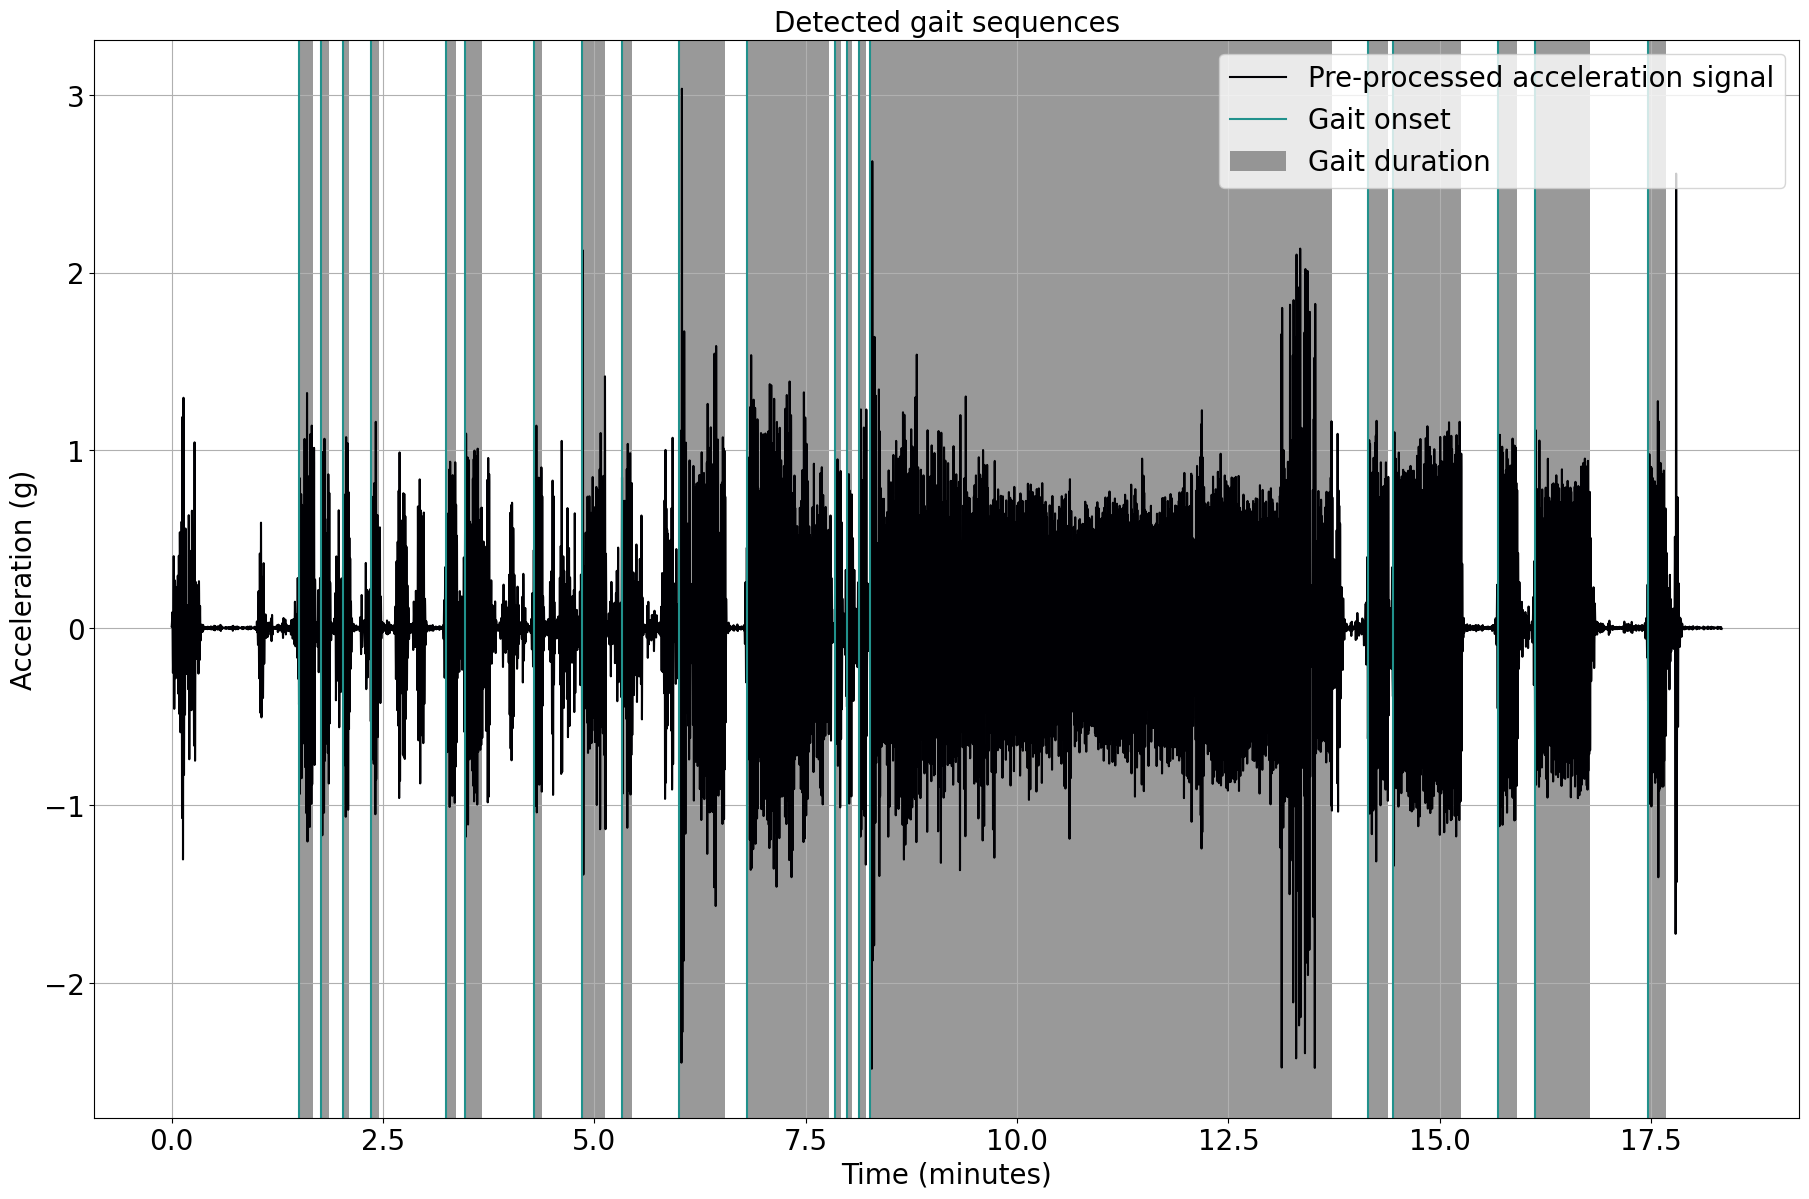

{'lowerBack':        onset  duration     event_type tracking_system
0     90.175    10.400  gait sequence            None
1    106.075     5.600  gait sequence            None
2    121.750     4.250  gait sequence            None
3    141.275     5.525  gait sequence            None
4    195.025     7.100  gait sequence            None
5    207.850    12.325  gait sequence            None
6    256.925     5.900  gait sequence            None
7    291.175    16.650  gait sequence            None
8    319.450     7.100  gait sequence            None
9    360.350    32.375  gait sequence            None
10   408.125    58.650  gait sequence            None
11   470.975     4.275  gait sequence            None
12   479.150     3.600  gait sequence            None
13   488.100     4.650  gait sequence            None
14   495.875   327.350  gait sequence            None
15   848.875    14.300  gait sequence            None
16   867.025    47.975  gait sequence            None
17   940.975  

In [17]:
# Create an instance of the ParaschivIonescuGaitSequenceDetection class
gsd = ParaschivIonescuGaitSequenceDetection()

# Call the gait sequence detection using gsd.detect
gsd = gsd.detect(
    data=recording.data["imu"], sampling_freq_Hz=fs, plot_results=True, dt_data=None
)

# Gait sequences are stored in gait_sequences_ attribute of gsd
gait_sequences = gsd.gait_sequences_

# Add events to the recording as a dictionary including tracking system and events
gait_sequence_events = gait_sequences
recording.add_events(tracking_system=tracked_point, new_events=gait_sequence_events)

# Show events and their corresponding information
print(recording.events)

That seemed to work. Let's see how many gait sequences we found and how long they lasted on average.

In [18]:
n_gs = len(recording.events["lowerBack"])
mean_dur = recording.events["lowerBack"]["duration"].mean()
print(f"Mean duration of gait {n_gs:.0f} sequences: {mean_dur:.2f} seconds")

# also check the longest gait sequence
max_dur = recording.events["lowerBack"]["duration"].max()
max_dur_onset = recording.events["lowerBack"]["onset"][recording.events["lowerBack"]["duration"].idxmax()]
print(f"Longest gait sequence: {max_dur:.2f} seconds starting at about {max_dur_onset/60:.2f} minutes into the recording.")


Mean duration of gait 20 sequences: 31.67 seconds
Longest gait sequence: 327.35 seconds starting at about 8.26 minutes into the recording.


That's it for this tutorial. You have learned how to load data and channel information into an `KielMATRecording` object and how to add Recording specific information to the `KielMATRecording` object. 